In [98]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
from torch import load as torch_load
import seaborn as sns
import pandas as pd
from ipywidgets import widgets
from ipywidgets import interact, fixed


ETM = torch_load('ETM_guardian_environment_skipgram_30_parameters.pt')
theta = ETM['theta']
alpha = ETM['alpha']
rho = ETM['rho']
beta = ETM['beta']
vocab = ETM['vocab']
num_topics = alpha.shape[0]
K = 5

In [87]:
# TSNE + SCATTERPLOT TOPIC AND WORDS

# DA NON UTILIZZARE (VEDI LE DUE FUNZIONI SOTTO)

def tsne_visualize1(alpha,rho,beta,topwords=10):
    topics=alpha.shape[0]
    alpha_rho=np.vstack((alpha, rho))
    tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(alpha_rho)
    topK=np.argsort(-1 * beta, axis=1)[:,0:topwords]
    topKvect=np.concatenate(topK)
    indexes = list(range(topics))
    for i in list(topKvect):
        indexes.append(i)
    tsne_lda_topK=tsne_lda[indexes,]
    
    colours=list(range(topics))
    markers=list(np.repeat('D',topics))
    for i in range(topics):
        for j in range(topwords):
            colours.append(i)
            markers.append('.')
    
    colormap = []
    for name, hex in matplotlib.colors.cnames.items():
        colormap.append(hex)
    colormap = colormap[:tsne_lda_topK.shape[0]]
    colormap = list(np.array(colormap))
    colours2 = [colormap[c] for c in colours]
    
    fig, ax = plt.subplots(figsize=(16,8))
   # plt.figure(figsize = (16,8))
    plt.rcParams['font.size'] = '12'
    sns.set(style = 'darkgrid')
   # plt.scatter(x=tsne_lda_topK[topics:, 0], y=tsne_lda_topK[topics:, 1], c=colours2[topics:], marker='.', label='Words')
    ax.scatter(x=tsne_lda_topK[:topics, 0], y=tsne_lda_topK[:topics, 1], c=colours2[:topics], marker='D', label='Topics')
    for i in list(range(topics)):
        ax.annotate(i, (tsne_lda_topK[i,0],tsne_lda_topK[i,1]))
    plt.title('TSNE dimensionality reduction', fontsize = 16)
    plt.legend(loc='best')
    #plt.xlim(-2, 2.5)
    #plt.ylim(-3, 3)
    plt.show()

In [95]:
def tsne_visualize_topics(alpha):
    topics=alpha.shape[0]
    tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
    tsne_alpha = tsne_model.fit_transform(alpha)
    indexes = list(range(topics))
    
    colours=list(range(topics))    
    colormap = []
    for name, hex in matplotlib.colors.cnames.items():
        colormap.append(hex)
    colormap = colormap[:tsne_alpha.shape[0]]
    colormap = list(np.array(colormap))
    colours2 = [colormap[c] for c in colours]
    
    fig, ax = plt.subplots(figsize=(16,8))
   # plt.figure(figsize = (16,8))
    plt.rcParams['font.size'] = '12'
    sns.set(style = 'darkgrid')
   # plt.scatter(x=tsne_lda_topK[topics:, 0], y=tsne_lda_topK[topics:, 1], c=colours2[topics:], marker='.', label='Words')
    ax.scatter(x=tsne_alpha[:, 0], y=tsne_alpha[:, 1], c=colours2[:], marker='D', label='Topics')
    for i in list(range(topics)):
        ax.annotate(i, (tsne_alpha[i,0],tsne_alpha[i,1]))
    plt.title('TSNE dimensionality reduction', fontsize = 16)
    plt.legend(loc='best')
    #plt.xlim(-2, 2.5)
    #plt.ylim(-3, 3)
    plt.show()

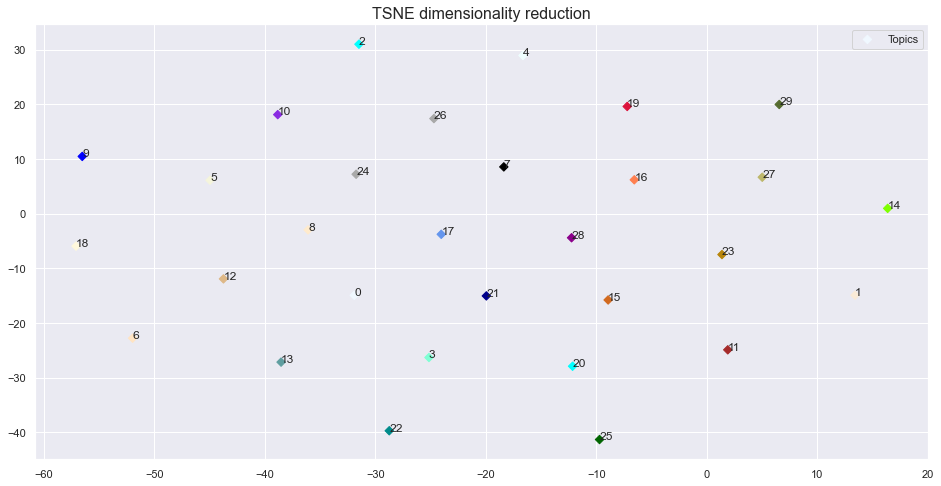

In [96]:
tsne_visualize_topics(alpha)

[3486,
 6515,
 1428,
 2102,
 6211,
 1620,
 4808,
 376,
 3639,
 1749,
 1378,
 2465,
 1971,
 1450,
 3120,
 6903,
 3875,
 1908,
 2220,
 114,
 6032,
 4491,
 4117,
 5987,
 806,
 4159,
 2638,
 6807,
 2674,
 6225,
 3998,
 4575,
 2157,
 1918,
 2111,
 2403,
 6629,
 5989,
 683,
 4418,
 6759,
 6755,
 7275,
 2157,
 2469,
 3119,
 5991,
 4575,
 6419,
 1732,
 3753,
 4197,
 1189,
 1564,
 6535,
 1097,
 4212,
 4239,
 835,
 1310,
 4843,
 2931,
 380,
 5935,
 3614,
 1793,
 5324,
 3092,
 5976,
 406,
 1850,
 6032,
 1092,
 972,
 2660,
 286,
 3876,
 6521,
 3763,
 3238,
 1924,
 5860,
 3259,
 5004,
 6247,
 2599,
 94,
 938,
 5913,
 372,
 681,
 5441,
 2121,
 1502,
 1639,
 5807,
 4024,
 1442,
 5223,
 6999,
 1029,
 6614,
 4215,
 3457,
 400,
 2980,
 6393,
 153,
 3234,
 6462,
 3810,
 5578,
 6221,
 5886,
 2293,
 5689,
 246,
 5860,
 5262,
 6527,
 2147,
 6489,
 519,
 5841,
 6513,
 2521,
 2950,
 6305,
 4667,
 3441,
 5369,
 6699,
 4287,
 2313,
 6198,
 6009,
 832,
 2576,
 188,
 516,
 726,
 3949,
 4197,
 2235,
 3056,
 5015,


[3486,
 6515,
 1428,
 2102,
 6211,
 1620,
 4808,
 376,
 3639,
 1749,
 1378,
 2465,
 1971,
 1450,
 3120,
 6903,
 3875,
 1908,
 2220,
 114,
 6032,
 4491,
 4117,
 5987,
 806,
 4159,
 2638,
 6807,
 2674,
 6225,
 3998,
 4575,
 2157,
 1918,
 2111,
 2403,
 6629,
 5989,
 683,
 4418,
 6759,
 6755,
 7275,
 2157,
 2469,
 3119,
 5991,
 4575,
 6419,
 1732,
 3753,
 4197,
 1189,
 1564,
 6535,
 1097,
 4212,
 4239,
 835,
 1310,
 4843,
 2931,
 380,
 5935,
 3614,
 1793,
 5324,
 3092,
 5976,
 406,
 1850,
 6032,
 1092,
 972,
 2660,
 286,
 3876,
 6521,
 3763,
 3238,
 1924,
 5860,
 3259,
 5004,
 6247,
 2599,
 94,
 938,
 5913,
 372,
 681,
 5441,
 2121,
 1502,
 1639,
 5807,
 4024,
 1442,
 5223,
 6999,
 1029,
 6614,
 4215,
 3457,
 400,
 2980,
 6393,
 153,
 3234,
 6462,
 3810,
 5578,
 6221,
 5886,
 2293,
 5689,
 246,
 5860,
 5262,
 6527,
 2147,
 6489,
 519,
 5841,
 6513,
 2521,
 2950,
 6305,
 4667,
 3441,
 5369,
 6699,
 4287,
 2313,
 6198,
 6009,
 832,
 2576,
 188,
 516,
 726,
 3949,
 4197,
 2235,
 3056,
 5015,


In [106]:
def tsne_visualize_words(rho,beta,topwords=10,topics=num_topics):
    tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(rho)
    topK=np.argsort(-1 * beta, axis=1)[:,0:topwords]
    topKvect=np.concatenate(topK)
    indexes = list(topKvect)
    tsne_lda_topK=tsne_lda[indexes,]
    
    colours=list()
    for i in range(topics):
        for j in range(topwords):
            colours.append(i)
    colormap = []
    for name, hex in matplotlib.colors.cnames.items():
        colormap.append(hex)
    colormap = colormap[:tsne_lda_topK.shape[0]]
    colormap = list(np.array(colormap))
    colours2 = [colormap[c] for c in colours]
    
   # fig, ax = plt.subplots(figsize=(16,8))
    plt.figure(figsize = (16,8))
    plt.rcParams['font.size'] = '12'
    sns.set(style = 'darkgrid')
    plt.scatter(x=tsne_lda_topK[topics:, 0], y=tsne_lda_topK[topics:, 1], c=colours2[topics:], marker='.', label='Words')
  #  ax.scatter(x=tsne_lda_topK[:topics, 0], y=tsne_lda_topK[:topics, 1], c=colours2[:topics], marker='D', label='Topics')
    for i in list(range(topics)):
        ax.annotate(i, (tsne_lda_topK[i,0],tsne_lda_topK[i,1]))
    plt.title('TSNE dimensionality reduction', fontsize = 16)
  #  plt.legend(loc='best')
    #plt.xlim(-2, 2.5)
    #plt.ylim(-3, 3)
    plt.show()

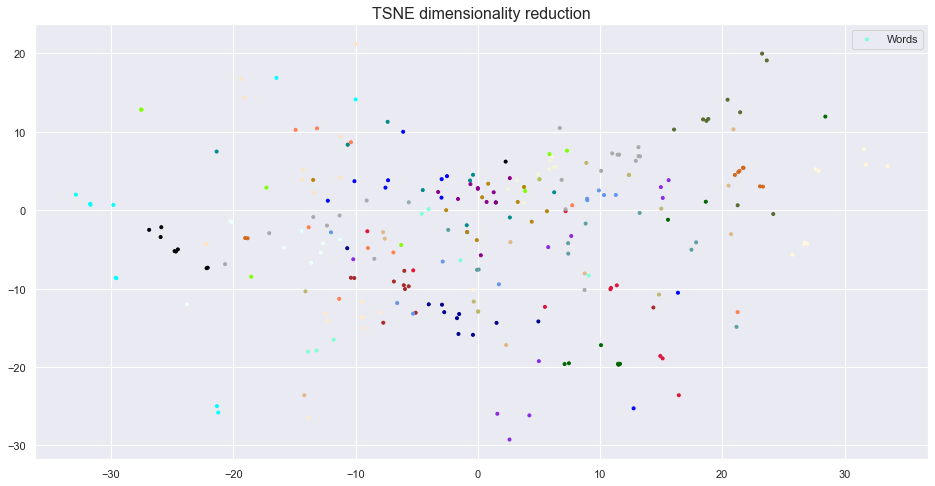

In [107]:
tsne_visualize_words(rho,beta,topwords=10,topics=num_topics)

In [136]:
def tsne_visualize_words_onetopic(rho,beta,topic_col,topwords=10,topics=num_topics):
    tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(rho)
    topK=np.argsort(-1 * beta, axis=1)[:,0:topwords]
    topKvect=np.concatenate(topK)
    indexes = list(topKvect)
    tsne_lda_topK=tsne_lda[indexes,]
    colours=list()
    for i in range(topics):
        if i==topic_col:
            for j in range(topwords):
                colours.append('#000000')
        else:
            for j in range(topwords):
                colours.append('#FFFFFF')
    
    # fig, ax = plt.subplots(figsize=(16,8))
    plt.figure(figsize = (14,6))
    plt.rcParams['font.size'] = '12'
    sns.set(style = 'darkgrid')
    plt.scatter(x=tsne_lda_topK[:, 0], y=tsne_lda_topK[:, 1], s=120, edgecolors='#000000', c=colours, marker='.', label='Words')
    #  ax.scatter(x=tsne_lda_topK[:topics, 0], y=tsne_lda_topK[:topics, 1], c=colours2[:topics], marker='D', label='Topics')
    for i in list(range(topics)):
        ax.annotate(i, (tsne_lda_topK[i,0],tsne_lda_topK[i,1]))
    plt.title('TSNE dimensionality reduction', fontsize = 16)
    #plt.legend(loc='best')
    #plt.xlim(-2, 2.5)
    #plt.ylim(-3, 3)
    plt.show()

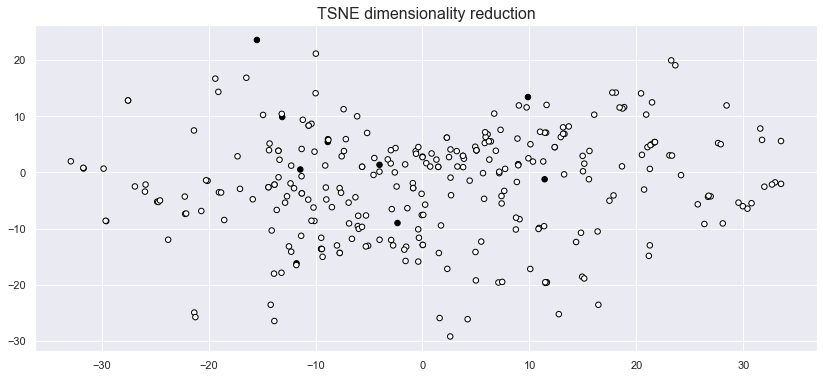

In [137]:
tsne_visualize_words_onetopic(rho,beta,topic_col=0,topwords=10,topics=num_topics)

In [140]:
interact(tsne_visualize_words_onetopic, topic_col=list((range(alpha.shape[0]))), topwords=list((5,10,15)), topics=fixed(alpha.shape[0]), beta=fixed(beta), rho=fixed(rho), )

interactive(children=(Dropdown(description='topic_col', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

<function __main__.tsne_visualize_words_onetopic(rho, beta, topic_col, topwords=10, topics=30)>

In [147]:
colormap[144]

'#FFFFFF'

In [141]:
tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
tsne_words = tsne_model.fit_transform(rho)

In [155]:
    colours=list()
    for i in range(topics):
        if i==topic_col:
            for j in range(topwords):
                colours.append(i)
        else:
            for j in range(topwords):
                colours.append(144)


In [185]:
def tsne_visualize_words_onetopic(tsne_words,beta,topic_col,topwords=10,topics=num_topics):
    topK=np.argsort(-1 * beta, axis=1)[:,0:topwords]
    topKvect=np.concatenate(topK)
    indexes = list(topKvect)
    tsne_lda_topK=tsne_lda[indexes,]
    colours=list()
    for i in range(topics):
        if i in topic_col:
            for j in range(topwords):
                colours.append(i)
        else:
            for j in range(topwords):
                colours.append(144)
    colormap = []
    for name, hex in matplotlib.colors.cnames.items():
        colormap.append(hex)
    colormap = colormap[:tsne_lda_topK.shape[0]]
    colormap = list(np.array(colormap))
    colours2 = [colormap[c] for c in colours]

    # fig, ax = plt.subplots(figsize=(16,8))
    plt.figure(figsize = (14,6))
    plt.rcParams['font.size'] = '12'
    sns.set(style = 'darkgrid')
    plt.scatter(x=tsne_lda_topK[:, 0], y=tsne_lda_topK[:, 1], s=120, c=colours2, marker='.', label='Words')
    #  ax.scatter(x=tsne_lda_topK[:topics, 0], y=tsne_lda_topK[:topics, 1], c=colours2[:topics], marker='D', label='Topics')
    for i in list(range(topics)):
        ax.annotate(i, (tsne_lda_topK[i,0],tsne_lda_topK[i,1]))
    plt.title('TSNE dimensionality reduction', fontsize = 16)
    #plt.legend(loc='best')
    #plt.xlim(-2, 2.5)
    #plt.ylim(-3, 3)
    plt.show()

In [170]:
1 in [1,2]

True

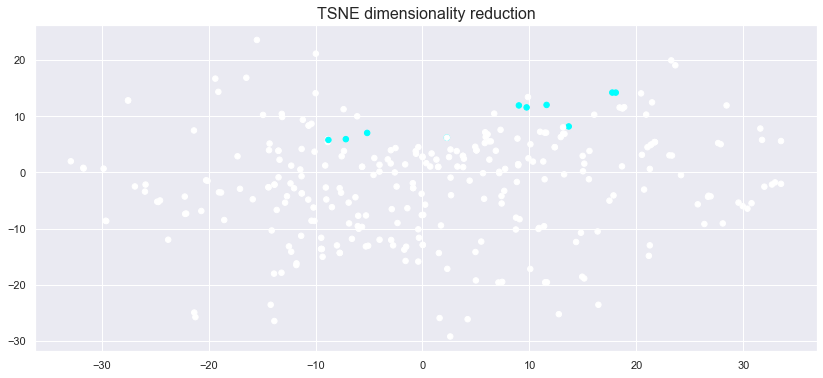

In [168]:
tsne_visualize_words_onetopic(tsne_lda,beta,topic_col=2,topwords=10,topics=num_topics)

In [201]:
import ipywidgets as widgets
data = ["data1", "data2", "data3", "data4"]
checkboxes = [widgets.Checkbox(value=False, description='Topic '+str(label)) for label in list(range(num_topics))]
output = widgets.VBox(topics=checkboxes)
display(output)

TypeError: 'module' object is not callable

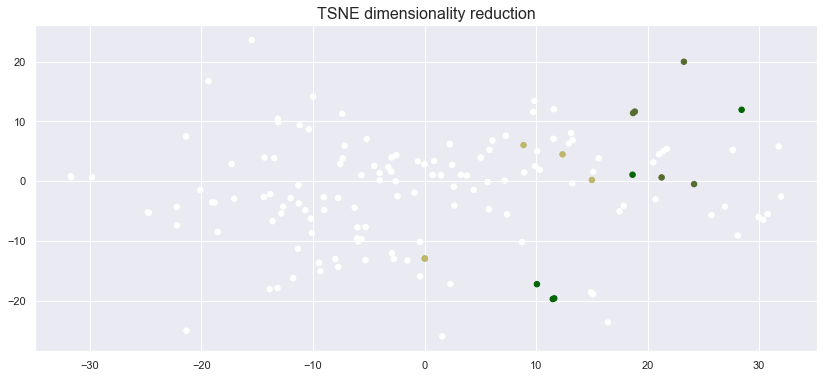

In [193]:
selected_topics = []
for i in range(len(checkboxes)):
    if checkboxes[i].value == True:
        selected_topics.append(i)
tsne_visualize_words_onetopic(tsne_lda,beta,topic_col=selected_topics,topwords=5,topics=num_topics)

In [205]:
interact(tsne_visualize_words_onetopic, topic_col=output, topwords=list((5,10,15)), topics=fixed(alpha.shape[0]), beta=fixed(beta), rho=fixed(rho), tsne_words=fixed(tsne_lda))

ValueError: VBox() cannot be transformed to a widget

In [48]:
# BARPLOT TOP WORDS PER TOPIC
#[str(i) for i in list((range(alpha.shape[0])))] 
def barplot_topwords(topic, beta, vocab, topwords=10):
    topK=np.argsort(-1 * beta[topic,])[0:topwords]
    data = {'word':[str(vocab[i]) for i in list(topK)],'beta':list(beta[topic,topK])}
    df = pd.DataFrame(data)
    
    fig, ax = plt.subplots(figsize = (9,5))
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)
        
    sns.barplot(x='beta', y='word', data = df, orient='h', edgecolor = 'black', color='steelblue')
    plt.title('Top ' + str(topwords) + ' words for topic ' + str(topic), fontsize = 18)
    plt.xlabel('Beta', fontsize = 18)
    plt.ylabel('Word', fontsize = 18)
    plt.show

In [72]:

interact(barplot_topwords, topic = list((range(alpha.shape[0]))), beta = fixed(beta), vocab = fixed(vocab), topwords=list((10,15,20)))

interactive(children=(Dropdown(description='topic', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

<function __main__.barplot_topwords(topic, beta, vocab, topwords=10)>

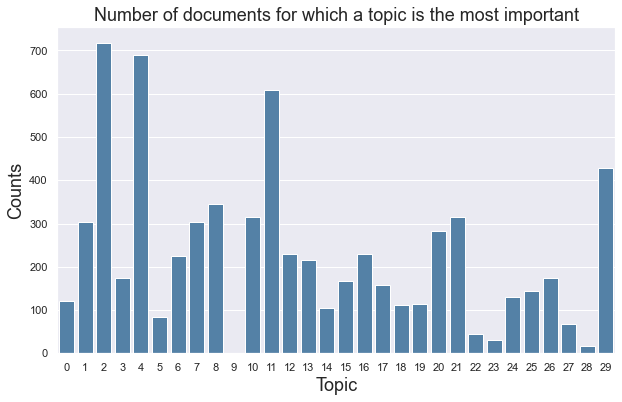

In [71]:
# BARPLOT NUM. DOCUMENTS IN WHICH A TOPIC IS THE MOST IMPORTANT

top_topics=list(np.argsort(-1 * theta, axis=1)[:,1])
count_top_topics=list()
for i in range(theta.shape[1]):
    count_top_topics.append((np.array(top_topics)==i).sum(axis=0))
data = {'topic':list(range(theta.shape[1])),'counts':count_top_topics}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x='topic', y='counts', data = df, color='steelblue')
plt.title('Number of documents for which a topic is the most important', fontsize = 18)
plt.xlabel('Topic', fontsize = 18)
plt.ylabel('Counts', fontsize = 18)
plt.show()


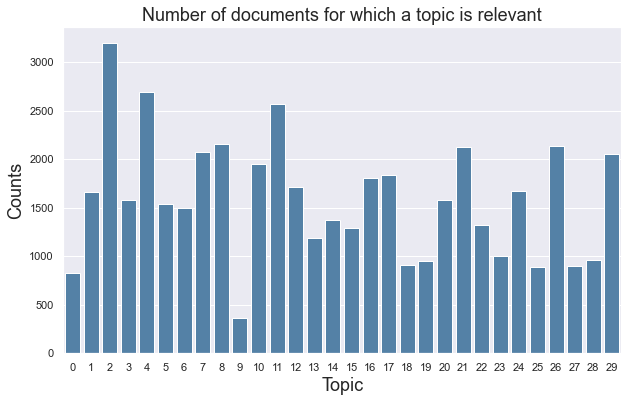

In [73]:
# BARPLOT NUM. DOCUMENTS IN WHICH A TOPIC IS DETECTED (Θ above a threshold)

theta_threshold=1/theta.shape[1]
topic_ndocs=(theta>theta_threshold).sum(axis=0)
data = {'topic':list(range(theta.shape[1])),'ndocs':list(topic_ndocs)}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x='topic', y='ndocs', data = df, color = 'steelblue')
plt.title("Number of documents for which a topic is relevant", fontsize = 18)
plt.xlabel('Topic', fontsize = 18)
plt.ylabel('Counts', fontsize = 18)
plt.show()

In [55]:
# TOPIC DISTRIBUTION BY DOCUMENT

def get_doc_representation(theta, doc):
    data = {'topic':list(range(theta.shape[1])),'distrib':list(theta[doc,])}
    df = pd.DataFrame(data)
    fig, ax = plt.subplots(figsize = (10,6))
    sns.barplot(x='topic', y='distrib', data = df, color='steelblue')
    plt.title('Topic distribution in doc '+ str(doc), fontsize = 18)
    plt.xlabel('Topic', fontsize = 18)
    plt.ylabel('topic importance in doc '+ str(doc), fontsize = 18)
    plt.show()


In [74]:
interact(get_doc_representation, theta=fixed(theta), doc=widgets.IntSlider(min=0,max=theta.shape[0]-1,step=1,value=0))

interactive(children=(IntSlider(value=0, description='doc', max=6844), Output()), _dom_classes=('widget-intera…

<function __main__.get_doc_representation(theta, doc)>

In [75]:
# HISTOGRAM NUM. WORDS IN EACH DOCUMENT

#length_docs=np.random.poisson(lam=1000, size=theta.shape[0])
sns.histplot(length_docs).set(xlabel='num. words', ylabel='counts')
plt.axvline(np.mean(length_docs), linewidth=2.5, color='black')
plt.axvline(np.percentile(length_docs, 25), linestyle='--', color='black')
plt.axvline(np.percentile(length_docs, 50), linestyle='--', color='black')
plt.axvline(np.percentile(length_docs, 75), linestyle='--', color='black')
plt.legend('topright', labels=['mean', 'quartiles'])
plt.show()


NameError: name 'length_docs' is not defined

In [ ]:
# METRICS PLOT TO COMPARE METHODS
# metrics = 2-dim array, rows: methods, columns: num topic
# method_labels = list of strings with names of the methods
# num_topic = list of integers, ex. [10,20,30,40,50]

def metrics_plot(metrics,method_labels,num_topic):
    for i in range(num_metrics):
        plt.plot(num_topic,metrics[i,], label=method_labels[i])
    plt.legend()
    plt.xticks(num_topic)
    plt.show()